In [39]:
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
# from datasets import mitdb as dm


ModuleNotFoundError: No module named 'datasets'

/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_46778/2526789604.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',
/var/folders/hd/p3q1ts813gq7flnfjj_xpf440000gp/T/ipykernel_46778/2526789604.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x',


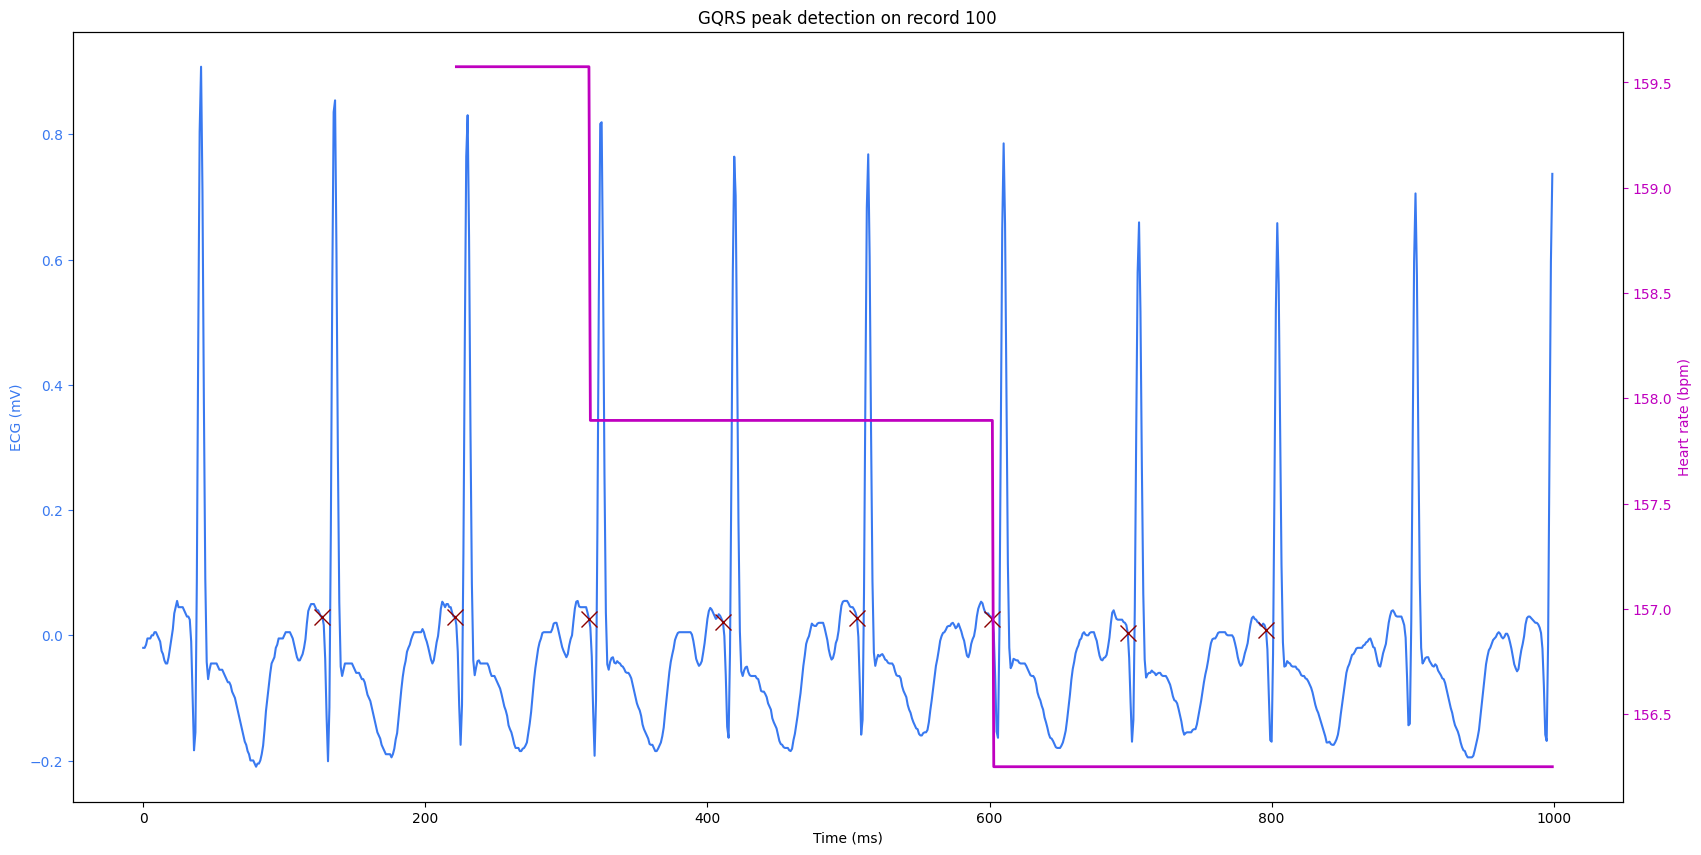

Orignal ECG Graph


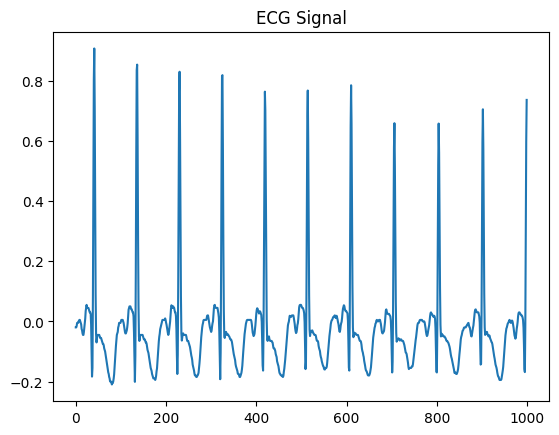

Corrected GQRS detected peak indices: [136, 230, 325, 419, 514, 610, 706, 804]


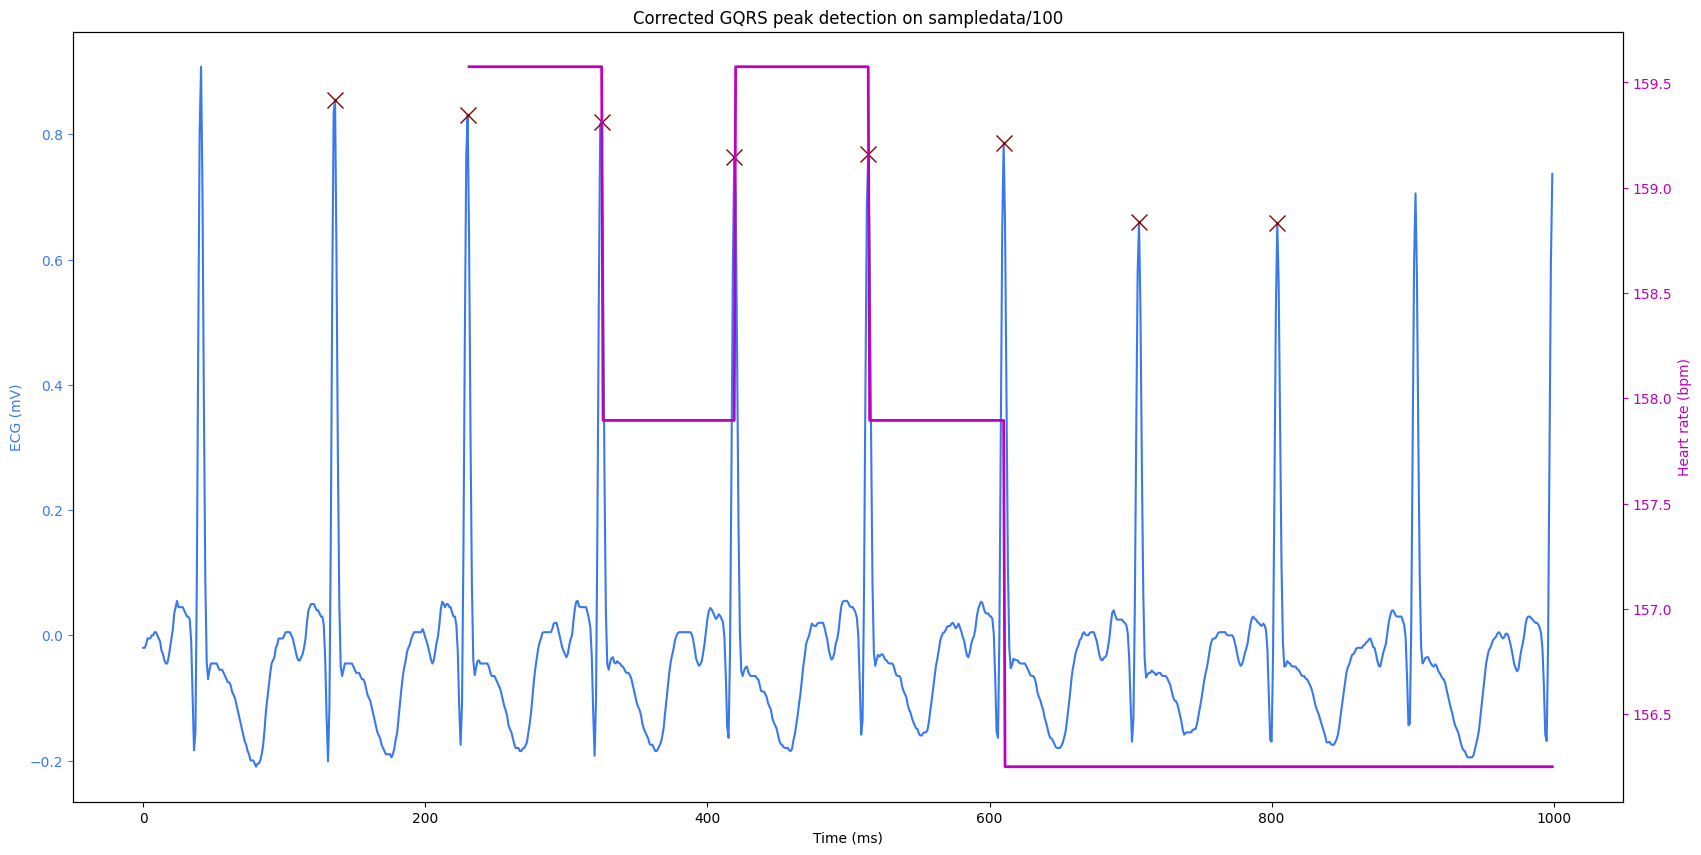

In [75]:
# Use the GQRS detection algorithm and correct the peaks
def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the WFDB record and the physical samples
data_dir = "../DataSet/files/picsdb/1.0.0/infant1_ecg"
data_resp_dir = "../DataSet/files/picsdb/1.0.0/infant1_resp"
sampfrom = 0
sampto = 1000

record = wfdb.rdrecord(data_dir, sampfrom = sampfrom, sampto = sampto)

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig = record.p_signal, fs = record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print("Orignal ECG Graph")
record = wfdb.rdrecord(data_dir, sampfrom=sampfrom, sampto=sampto)

# 转为数字信号
signal = record.p_signal

# 绘制波形
plt.plot(signal)
plt.title("ECG Signal")
plt.show()

print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on sampledata/100")


this is the test to read .atr.sample
{'record_name': 'infant1_ecg', 'extension': 'atr', 'sample': array([], dtype=int64), 'symbol': [], 'subtype': array([], dtype=int64), 'chan': array([], dtype=int64), 'num': array([], dtype=int64), 'aux_note': [], 'fs': 250, 'label_store': None, 'description': None, 'custom_labels':     label_store symbol        description
42           42      [  bradycardia onset, 'contained_labels': None, 'ann_len': 0}
[]
0


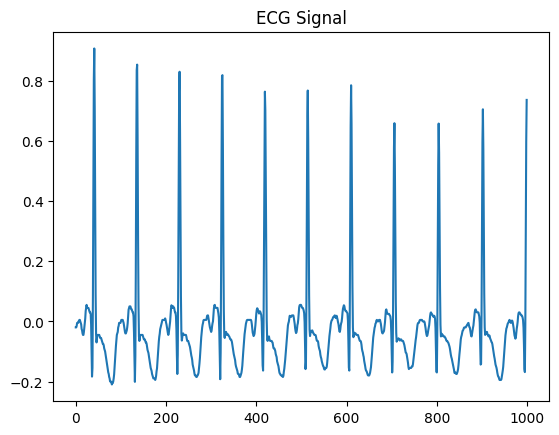

In [4]:
#获取R峰位置，截取心拍

#每个心拍记录中的 annotation 是有标注R峰位置的。目前，截取各个心拍的方法主要是根据 R峰 的位置分别向前、
#向后取一段距离为一个心拍；

import wfdb
import matplotlib.pyplot as plt

# print(record.__dict__)
# display(record.__dict__)

# 转为数字信号
signal = record.p_signal

# 绘制波形
plt.plot(signal)
plt.title("ECG Signal")


# 读取annatations
signal_ann = wfdb.rdann(data_dir, "atr", sampfrom=0, sampto=1000)
print('this is the test to read .atr.sample')
print(signal_ann.__dict__)
print(signal_ann.sample)
print(len(signal_ann.sample))

# 将读取到的annatations的心拍绘制到心电图上
for index in signal_ann.sample:
    plt.scatter(index, signal[index][0], marker="*")

# # 并打印出改心拍标注的类型
# print(signal_ann.symbol)
plt.show()


In [ ]:
####完整代码

In [5]:
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense, Attention, multiply
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.python.keras.layers.core import *
from tensorflow.python.keras.utils.vis_utils import plot_model
from wfdb import processing

# 测试集在数据集中所占的比例
RATIO = 0.2
data_dir = "../DataSet/files/picsdb/1.0.0/infant1_ecg"

# 小波去噪预处理
def denoise(data):
    # 小波变换 
    # 用db5作为小波基，对心电数据进行9尺度小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    ## 将高频信号cD1、cD2置零
    cD1.fill(0)
    cD2.fill(0)
    ## 将其他中低频信号按软阈值公式滤波
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata
        

# 读取心电数据和对应标签,并对数据进行小波去噪
# data_dir = "../tset01/physionet.org/files/picsdb/1.0.0"
def getDataSet(number, X_data, Y_data): #(number, X_data, Y_data):
    ecgClassSet = ['N', 'A', 'V', 'L', 'R']
    # N Normal beat
    # A Atrial premature contraction房性早搏
    # V Premature ventricular contraction室性早搏
    # L Left bundle branch block beat左束支传导阻滞搏动
    # R Right bundle branch block beat右束支传导阻滞搏动
    
    # 读取心电数据记录
    print("正在读取 " + number + " 号心电数据...")
    
    # 读取导联的数据
    record = wfdb.rdrecord(data_dir)
    r_peaks = wfdb.rdann(data_dir,'qrsc')
    resp_peaks = wfdb.rdann(data_resp_dir,'resp')
    data = record.p_signal.flatten()   ##############
    rdata = denoise(data=data) 
    
    print("data", data)
    print("rdata", rdata)

    # 获取心电数据记录中R波的位置和对应的标签， 这里只是提取数据
    annotation = wfdb.rdann(data_dir,'atr')
    Rlocation = annotation.sample 
    Rclass = annotation.symbol
    
    print("annotation", annotation)
    print("Rlocation", Rlocation)
    print("Rclass", Rclass)

    
#     去掉前后的不稳定数据
    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end   #len(annotation.symbol)=77 j=77-5=72

    # 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
    while i < j:
        try:
            # Rclass[i] 是标签 
            print("Rclass[i]", Rclass[i])
            lable = ecgClassSet.index(Rclass[i])
#             x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
#             X_data.append(x_train)
#             Y_data.append(lable) # lable = ecgClassSet.index(Rclass[i])  Rclass[i]=annotation.symbol[i]
            i += 1
        except ValueError:
            print("Error Data", ValueError)
            i += 1
    return
    
    
# 加载数据集并进行预处理
def loadData():
    numberSet = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    dataSet = []
    lableSet = []
    for n in numberSet:
        getDataSet(n, dataSet,lableSet) #n=number  dataSet=X_data  lableSet=Y_data=0？

        
    print("dataSet: ",dataSet)
    print("lableSet: ",lableSet)

    # 转numpy数组,打乱顺序
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))   #？？？？？？？
    np.random.shuffle(train_ds)

    # 数据集及其标签集
    X = train_ds[:, :300].reshape(-1, 300, 1)
    Y = train_ds[:, 300]
    print("X: ",X)
    print("Y: ",Y)

    
    # 测试集及其标签集
    shuffle_index = np.random.permutation(len(X))
    print("shuffle_index: ",shuffle_index)

    # 设定测试集的大小 RATIO是测试集在数据集中所占的比例
    test_length = int(0.2 * len(shuffle_index))
    print("test_length: ",test_length)
    # 测试集的长度
    test_index = shuffle_index[:test_length]
    # 训练集的长度
    train_index = shuffle_index[test_length:]
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]
    return X_train, Y_train, X_test, Y_test


In [44]:
# 构建CNN模型
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # 第一个卷积层, 4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='tanh'),
        # 第一个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第二个卷积层, 16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        # 第二个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第三个卷积层, 32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='tanh'),
        # 第三个池化层, 平均池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第四个卷积层, 64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        # 打平层,方便全连接层处理'
        tf.keras.layers.Flatten(),
        # 全连接层,128 个节点 转换成128个节点
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout层,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # 全连接层,5 个节点
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel

def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # 绘图
    plt.figure(figsize=(4, 5))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


# X_train,Y_train为所有的数据集和标签集
# X_test,Y_test为拆分的测试集和标签集
X_train, Y_train, X_test, Y_test = loadData()
# print(X_train.shape)

# model = buildModel()
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy', metrics=['accuracy']
#               # metrics: 列表，包含评估模型在训练和测试时的性能的指标，典型用法是metrics=[‘accuracy’]。
#               )
# model.summary()

# # plotHeatMap()
# # 训练与验证
# model.fit(X_train, Y_train, validation_split = "linear")  # validation_split 训练集所占比例
# # 预测
# Y_pred = model.predict(X_test)
# print(Y_pred)


正在读取 1 号心电数据...
data [-0.01998352 -0.01998352 -0.01498764 ... -0.31474046 -0.07868511
  0.33597295]
rdata [-0.01270703 -0.01235147 -0.0112993  ... -0.047532    0.05009183
  0.16240631]
annotation <wfdb.io.annotation.Annotation object at 0x297dbf490>
Rlocation [  492843   864128   984499  1208687  1924068  2061665  3277415  3671197
  4092936  4279525  4474989  4960095  6131606  6380121  7580334  8839650
  9948807 11393804 12506763 13091675 13870835 14742871 15166275 15326326
 15483730 15973421 16224718 17529945 18150760 18243747 19242692 19470997
 19937850 20253096 20736260 21234763 21333504 21676097 21979795 22498931
 22737631 23086767 23304355 23903101 24344758 24437056 24768375 25644652
 25811592 26068648 26316024 27050032 27513120 27796679 28875005 29505771
 29862851 30226051 31105267 31306300 31430173 31692956 32108501 32792265
 33124169 34681283 35165114 35667578 36541041 36957758 37056744 37365509
 37940274 38815618 39722902 40109190 40207931]
Rclass ['[', '[', '[', '[', '[', '['

data [-0.01998352 -0.01998352 -0.01498764 ... -0.31474046 -0.07868511
  0.33597295]
rdata [-0.01270703 -0.01235147 -0.0112993  ... -0.047532    0.05009183
  0.16240631]
annotation <wfdb.io.annotation.Annotation object at 0x297dbce80>
Rlocation [  492843   864128   984499  1208687  1924068  2061665  3277415  3671197
  4092936  4279525  4474989  4960095  6131606  6380121  7580334  8839650
  9948807 11393804 12506763 13091675 13870835 14742871 15166275 15326326
 15483730 15973421 16224718 17529945 18150760 18243747 19242692 19470997
 19937850 20253096 20736260 21234763 21333504 21676097 21979795 22498931
 22737631 23086767 23304355 23903101 24344758 24437056 24768375 25644652
 25811592 26068648 26316024 27050032 27513120 27796679 28875005 29505771
 29862851 30226051 31105267 31306300 31430173 31692956 32108501 32792265
 33124169 34681283 35165114 35667578 36541041 36957758 37056744 37365509
 37940274 38815618 39722902 40109190 40207931]
Rclass ['[', '[', '[', '[', '[', '[', '[', '[', '[',

data [-0.01998352 -0.01998352 -0.01498764 ... -0.31474046 -0.07868511
  0.33597295]
rdata [-0.01270703 -0.01235147 -0.0112993  ... -0.047532    0.05009183
  0.16240631]
annotation <wfdb.io.annotation.Annotation object at 0x297dbe320>
Rlocation [  492843   864128   984499  1208687  1924068  2061665  3277415  3671197
  4092936  4279525  4474989  4960095  6131606  6380121  7580334  8839650
  9948807 11393804 12506763 13091675 13870835 14742871 15166275 15326326
 15483730 15973421 16224718 17529945 18150760 18243747 19242692 19470997
 19937850 20253096 20736260 21234763 21333504 21676097 21979795 22498931
 22737631 23086767 23304355 23903101 24344758 24437056 24768375 25644652
 25811592 26068648 26316024 27050032 27513120 27796679 28875005 29505771
 29862851 30226051 31105267 31306300 31430173 31692956 32108501 32792265
 33124169 34681283 35165114 35667578 36541041 36957758 37056744 37365509
 37940274 38815618 39722902 40109190 40207931]
Rclass ['[', '[', '[', '[', '[', '[', '[', '[', '[',

data [-0.01998352 -0.01998352 -0.01498764 ... -0.31474046 -0.07868511
  0.33597295]
rdata [-0.01270703 -0.01235147 -0.0112993  ... -0.047532    0.05009183
  0.16240631]
annotation <wfdb.io.annotation.Annotation object at 0x297dbfcd0>
Rlocation [  492843   864128   984499  1208687  1924068  2061665  3277415  3671197
  4092936  4279525  4474989  4960095  6131606  6380121  7580334  8839650
  9948807 11393804 12506763 13091675 13870835 14742871 15166275 15326326
 15483730 15973421 16224718 17529945 18150760 18243747 19242692 19470997
 19937850 20253096 20736260 21234763 21333504 21676097 21979795 22498931
 22737631 23086767 23304355 23903101 24344758 24437056 24768375 25644652
 25811592 26068648 26316024 27050032 27513120 27796679 28875005 29505771
 29862851 30226051 31105267 31306300 31430173 31692956 32108501 32792265
 33124169 34681283 35165114 35667578 36541041 36957758 37056744 37365509
 37940274 38815618 39722902 40109190 40207931]
Rclass ['[', '[', '[', '[', '[', '[', '[', '[', '[',

In [21]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)


model = buildModel()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy']
              # metrics: 列表，包含评估模型在训练和测试时的性能的指标，典型用法是metrics=[‘accuracy’]。
              )
model.summary()

(0, 300, 1) (0,) (0, 300, 1) (0,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 300, 4)            88        
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 150, 4)           0         
 1D)                                                             
                                                                 
 conv1d_17 (Conv1D)          (None, 150, 16)           1488      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 75, 16)           0         
 1D)                                                             
                                                                 
 conv1d_18 (Conv1D)          (None, 75, 32)            12832     
                                                                 
 average_pooling1d_4

In [16]:
# plotHeatMap(Y_test,Y_train)
# 训练与验证
model.fit(X_train, Y_train, validation_split = "linear")  # validation_split 训练集所占比例
# 预测
Y_pred = model.predict(X_test)
print(Y_pred)

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [ ]:
for i in range(1,11):
    
    data_dir = "../DataSet/files/picsdb/1.0.0/infant1_ecg"
    data_resp_dir = "../DataSet/files/picsdb/1.0.0/infant1_resp"
    record = wfdb.rdrecord('C:/Users/JoyceYing/siteEnv/machineTest/physionet.org/files/picsdb/1.0.0/infant{}_ecg'.format(i))
    ecg_record = wfdb.rdann('C:/Users/JoyceYing/siteEnv/machineTest/physionet.org/files/picsdb/1.0.0/infant{}_ecg'.format(i),'atr')
    annotation = wfdb.rdann('C:/Users/JoyceYing/siteEnv/machineTest/physionet.org/files/picsdb/1.0.0/infant{}_ecg'.format(i),'qrsc')
    sample = ecg_record.sample
    print(sample)
    
    X = record.p_signal
    y= annotation.sample

    
    if len(X) < 2 or len(y) < 2:

    
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, r_peaks, test_size=0.2, random_state=42)

        # Save the data as .npy files
        np.save('X_train.npy', X_train)
        np.save('y_train.npy', y_train)
        np.save('X_test.npy', X_test)
        np.save('y_test.npy', y_test)


In [53]:
data_dir = "../DataSet/files/picsdb/1.0.0/infant1_ecg"

record = wfdb.rdrecord(data_dir)
annotation = wfdb.rdann(data_dir,'atr')

record
annotation

# display(record.__dict__)
# Print some meta informations
print('Sampling frequency used for this record:', record.fs)
print('Shape of loaded data array:', record.p_signal.shape)
# print('Number of loaded annotations:', len(annotation.annids))
print('Third annotation is of type:', annotation.symbol[2])

Sampling frequency used for this record: 250
Shape of loaded data array: (41052191, 1)
Third annotation is of type: [


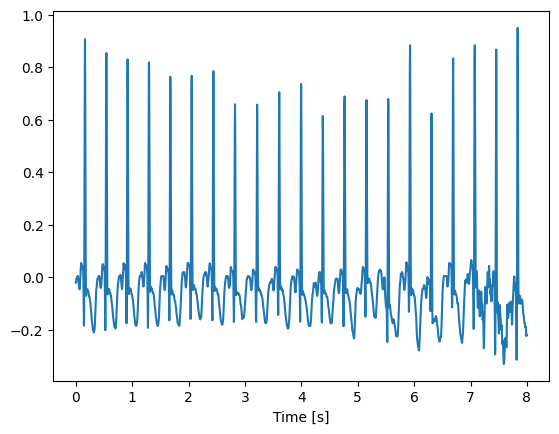

In [54]:
# Select one of the channels (there are two)
chid = 0
data = record.p_signal
channel = data[:, chid]

# print('ECG channel type:', record.signame[chid])

# Plot only the first 2000 samples
howmany = 2000

# Calculate time values in seconds
times = np.arange(howmany, dtype = 'float') / record.fs
plt.plot(times, channel[ : howmany])
plt.xlabel('Time [s]')
plt.show()

In [73]:
"""
The MIT arrhythmia database contains 48 records, each with 2 signals of 650000 samples. That totals to over 
60 million samples or 120 thousand fragments with 500 samples width. This number can be easily increased by signal augmentation, generation of artificial signals, inclusion of other databases, reducing the fragmenting window’s width and stride, etc.
First function we will need to generate our data set 
should convert a raw signal and it’s annotations into the desired output signals.

"""
def beat_annotations(annotation):
    """ Get rid of non-beat markers """
    # Declare beat types
    good = ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?']
    print("beats",annotation.symbol)
    ids = np.in1d(annotation.symbol, good)

    # We want to know only the positions
    beats = annotation.sample[ids]
    print("beats",beats)
    return beats

def convert_input(channel, annotation):
    """ Into output """
    # Remove non-beat annotations
    beats = beat_annotations(annotation)

    # Create dirac-comb signal
    dirac = np.zeros_like(channel)
    dirac[beats] = 1.0

    # Use hamming window as a bell-curve filter
    width = 36
    kernel = ss.hamming(width)
    gauss = np.convolve(kernel, dirac, mode = 'same')

    return dirac, gauss

"""
From 48 available data files we will use 30 for training,
9 for validation and 9 for final testing. Each of those
will be generated in the form of a Numpy array and later
accessed to pull data batches out. Unless amount of data
you will be operating on does not exceed your machine’s memory 
capabilities, an abstract function creating and saving a
proper set of arrays should be fairly simple.
"""
def make_dataset(records, savepath):
    """ Inside an array """
    # Prepare containers
    signals, labels = [], []
    path = "../DataSet/files/picsdb/1.0.0/infant1_ecg"

    # Iterate files
    # TODO: for path in records:
    record = wfdb.rdrecord(path)
    annotations = wfdb.rdann(path, 'atr')

    # Extract pure signals
    data = record.p_signal

    # Convert each channel into labeled fragments
    signal, label = convert_input(data, annotations)

    # Cumulate
    signals.append(signal)
    labels.append(label)

    # Convert to numpy.array
    signals = np.array(signals)
    labels = np.array(labels)

    # Write to disk
    np.save(savepath, {'signals' : signals, 'labels'  : labels })
    
    
    
"""
All of the data pre-processing, manipulations and 
chopping must be handled inside the convert_data() function,
specifically the window width must be controlled there.
Splitting the data boils down to choosing the ECG records 
for each of the data-set.

"""
def create_datasets():
    """ Training, validation, test """
    print("Creating data sets...")
    
    # Prepare paths
    print("Preparing Paths...")
    data_dir = "../DataSet/files/picsdb/1.0.0/infant1_ecg"
    records = wfdb.rdrecord(data_dir).p_signal

    # Shuffle up deterministically
    np.random.seed(666)
    np.random.shuffle(records)

    print("record", records)
    # Make training ...
    print("Making Training...")
    make_dataset(records[:30], 'data/training')

    # ... validation ...
    print("Making validation...")
    make_dataset(records[30 : 39], 'data/validation')

    # ... and test
    print("Making testing...")
    make_dataset(records[39 : 48], 'data/test')
    
    
"""
Data-set access
To train any neural network using this data, 
we need to provide a mechanism for extracting randomized 
batches of any given shape. You might have come across a 
Tensorflow implementation for the MNIST data set. 
We are going to use similar approach, focusing on the 
next_batch() function.
"""    
def next_batch(self, batch_size):
    """ Iterate """
    # Go forth
    start = self.index_in_epoch
    self.index_in_epoch += batch_size

    if self.index_in_epoch > self.nof_examples:
        # Finished epoch
        self.epochs_completed += 1
        print('Data epochs done:', self.epochs_completed)

        # Shuffle the data accessing iterators (again)
        np.random.shuffle(self.ids)

        # Start next epoch
        start = 0
        self.index_in_epoch = batch_size

    end = self.index_in_epoch

    # Get random row numbers
    ids = self.ids[start : end]

    signals = self.training_set['signals'][ids]
    labels = self.training_set['labels'][ids]

    return signals, labels

In [74]:
beat_annotations(annotation)
create_datasets()

beats ['[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[']
beats []
Creating data sets...
Preparing Paths...
record [[-0.07368923]
 [ 0.03122425]
 [-0.14113362]
 ...
 [-0.00999176]
 [-0.03996704]
 [-0.08492996]]
Making Training...
beats ['[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[', '[']
beats []


NameError: name 'ss' is not defined